In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from highlight_text import fig_text
import pickle
from xgboost import XGBClassifier
import xgboost as xgb
import soccerdata as sd
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels
import socceraction.vaep.formula as formula
import utils
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
import numpy as np
from itertools import combinations_with_replacement
from sklearn.linear_model import LinearRegression
from mplsoccer import Pitch,FontManager,add_image
from scipy.stats import binned_statistic_2d

filename = "xg_model_wy.sav"
xg_model = pickle.load(open(filename, 'rb'))
xg_model

[11/14/23 01:12:14] INFO     Custom team name replacements loaded from                                ]8;id=927245;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=813182;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\_config.py#83\83]8;;\
                             C:\Users\aleex\soccerdata\config\teamname_replacements.json.                          

                    INFO     Custom league dict loaded from                                          ]8;id=116339;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=425443;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\_config.py#157\157]8;;\
                             C:\Users\aleex\soccerdata\config\league_dict.json.                                    

In [2]:
instat_x = 105 # largo del campo
instat_y = 68 # ancho del campo
box_x = 16.5 # medida área x
ancho_porteria = 7.32
box_y = box_x + ancho_porteria/2 # medida área y

In [3]:
comp = "ENG-Premier League"
season = 2223



ws = sd.WhoScored(leagues=comp, seasons=season)
games = ws.read_schedule()
matches = games[(games.home_team.str.contains("Arsenal")) | (games.away_team.str.contains("Arsenal"))].game_id.unique()

[11/14/23 01:12:15] INFO     Saving cached data to C:\Users\aleex\soccerdata\data\WhoScored           ]8;id=509877;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=371401;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\_common.py#89\89]8;;\

[11/14/23 01:12:46] INFO     patching driver executable                                              ]8;id=814657;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\undetected_chromedriver\patcher.py\patcher.py]8;;\:]8;id=310444;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\undetected_chromedriver\patcher.py#346\346]8;;\
                             C:\Users\aleex\appdata\roaming\undetected_chromedriver\undetected_chrom               
                             edriver.exe                                                                           

[11/14/23 01:12:49] INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=620573;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=861187;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

In [4]:
df_events = pd.DataFrame()
df_teams = pd.DataFrame()
df_players = pd.DataFrame()
it = 0
for m in matches:
    it +=1
    print("{:.0f} / {:.0f}".format(it,len(matches)))
    events, teams, players = utils.sd_match_events_spadl(comp, season, int(m), games,ws)
    teams['game_id'] = m
    df_events = pd.concat([df_events, events])
    df_teams = pd.concat([df_teams, teams])
    df_players = pd.concat([df_players, players])

1 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=415020;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=974861;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640674                                 ]8;id=228296;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=955878;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

C:\Users\aleex\anaconda3\lib\site-packages\utils.py:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\aleex\anaconda3\lib\site-packages\utils.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\aleex\anaconda3\lib\site-packages\utils.py:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

2 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=458408;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=587197;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640684                                 ]8;id=8599;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=744918;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

3 / 38


[11/14/23 01:12:50] INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=537751;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=591890;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640694                                 ]8;id=607684;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=773131;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

4 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=270695;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=107936;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640704                                 ]8;id=69370;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=252498;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

5 / 38


[11/14/23 01:12:51] INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=213204;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=112168;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640714                                 ]8;id=584779;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=113455;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

6 / 38


[11/14/23 01:12:52] INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=882735;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=586907;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640729                                 ]8;id=343652;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=904846;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

7 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=219574;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=341779;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640745                                 ]8;id=878363;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=832145;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

8 / 38


[11/14/23 01:12:53] INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=541708;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=790076;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640754                                 ]8;id=272745;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=223112;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

9 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=368733;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=821427;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640764                                 ]8;id=22386;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=837819;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

10 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=906892;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=893429;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640777                                 ]8;id=242413;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=460457;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

11 / 38


[11/14/23 01:12:54] INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=806756;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=809317;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640800                                 ]8;id=534465;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=676510;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

12 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=318914;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=346635;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640804                                 ]8;id=263125;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=94736;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

13 / 38


[11/14/23 01:12:55] INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=972154;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=334321;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640815                                 ]8;id=722743;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=609170;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

14 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=435245;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=219636;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640833                                 ]8;id=857668;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=498612;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

15 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=688365;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=74859;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

[11/14/23 01:12:56] INFO     [1/1] Retrieving game with id=1640834                                 ]8;id=206753;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=398697;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

16 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=244585;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=978534;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640845                                 ]8;id=621098;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=960865;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

17 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=286596;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=663412;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640854                                 ]8;id=776287;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=75855;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

18 / 38


[11/14/23 01:12:57] INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=751058;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=485860;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640872                                 ]8;id=49756;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=319243;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

19 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=605672;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=605809;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640876                                 ]8;id=885569;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=834044;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

20 / 38


[11/14/23 01:12:58] INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=377426;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=610327;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640904                                 ]8;id=764746;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=513940;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

21 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=460707;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=782136;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640916                                 ]8;id=167327;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=456911;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

22 / 38


[11/14/23 01:12:59] INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=255408;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=197793;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640784                                 ]8;id=118031;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=11774;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

23 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=578854;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=806301;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

[11/14/23 01:13:00] INFO     [1/1] Retrieving game with id=1640936                                 ]8;id=303144;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=908098;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

24 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=818293;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=799120;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640966                                 ]8;id=574251;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=212385;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

25 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=86677;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=552605;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

[11/14/23 01:13:01] INFO     [1/1] Retrieving game with id=1640734                                 ]8;id=280233;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=539903;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

26 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=727052;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=546651;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640875                                 ]8;id=670050;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=744429;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

27 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=485002;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=164009;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640901                                 ]8;id=755299;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=490602;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

28 / 38


[11/14/23 01:13:02] INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=130552;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=710411;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640915                                 ]8;id=970192;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=763722;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

29 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=972039;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=783274;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640935                                 ]8;id=545166;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=782757;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

30 / 38


[11/14/23 01:13:03] INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=899277;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=655084;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640965                                 ]8;id=228524;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=453507;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

31 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=831653;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=294857;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640982                                 ]8;id=234062;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=816089;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

32 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=999078;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=591947;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640988                                 ]8;id=553447;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=240428;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

33 / 38


[11/14/23 01:13:04] INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=696918;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=623880;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1641024                                 ]8;id=658123;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=956010;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

34 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=621631;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=534749;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1641025                                 ]8;id=744145;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=283695;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

35 / 38


[11/14/23 01:13:05] INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=189886;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=891306;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1641040                                 ]8;id=710222;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=774711;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

36 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=350222;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=634460;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1641045                                 ]8;id=114952;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=280965;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

37 / 38


                    INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=35608;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=285001;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1640995                                 ]8;id=258077;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=464415;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

38 / 38


[11/14/23 01:13:06] INFO     Retrieving game schedule of ENG-Premier League - 2223 from the cache  ]8;id=660042;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=908657;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/1] Retrieving game with id=1641003                                 ]8;id=201682;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=558038;file://C:\Users\aleex\AppData\Roaming\Python\Python39\site-packages\soccerdata\whoscored.py#683\683]8;;\

In [5]:
df_events = df_events[df_events.action_id.isna()==False]

In [6]:
df_events.reset_index(inplace=True)

In [7]:
shots = df_events[df_events.type_name=='shot']
shots['Cx'] = df_events.start_x.max() - shots['start_x'] # distancia vertical respecto a la línea de gol
shots['Cy'] = abs(shots['start_y'] - shots.start_y.max()/2) # distancia horizontal respecto al centro
shots["Distance"] = np.sqrt(shots["Cx"]**2 + shots["Cy"]**2)
shots['Angle'] = np.where(np.arctan(7.32 * shots["Cx"] / (shots["Cx"]**2 + shots["Cy"]**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * shots["Cx"] /(shots["Cx"]**2 + shots["Cy"]**2 - (7.32/2)**2)), np.arctan(7.32 * shots["Cx"] /(shots["Cx"]**2 + shots["Cy"]**2 - (7.32/2)**2)) + np.pi)
shots["D2"] = shots["Distance"]**2
shots["Cx2"] = shots["Cx"]**2
shots

C:\Users\aleex\AppData\Local\Temp\ipykernel_3156\3913595293.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\aleex\AppData\Local\Temp\ipykernel_3156\3913595293.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\aleex\AppData\Local\Temp\ipykernel_3156\3913595293.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

,index,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,end_x,start_y,...,result_name,bodypart_name,player_name,team_name,Cx,Cy,Distance,Angle,D2,Cx2
94,116,1640674,2442235721,1,198.0,13,279379.0,91.875,93.975,34.204,...,fail,foot_right,Gabriel Jesus,Arsenal,13.125,0.374,13.130328,0.543508,172.405501,172.265625
96,118,1640674,2442235751,1,200.0,13,380706.0,98.175,105.000,41.616,...,fail,foot_left,Gabriel Martinelli,Arsenal,6.825,7.786,10.353860,0.489365,107.202421,46.580625
181,211,1640674,2442238823,1,471.0,13,273257.0,89.880,103.740,46.376,...,fail,foot_left,Oleksandr Zinchenko,Arsenal,15.120,12.546,19.647303,0.288727,386.016516,228.614400
189,219,1640674,2442239097,1,487.0,13,238940.0,86.205,91.980,38.148,...,fail,foot_right,Thomas Partey,Arsenal,18.795,4.318,19.284635,0.366431,371.897149,353.252025
413,481,1640674,2442248953,1,1155.0,13,380706.0,100.695,105.000,32.640,...,success,head,Gabriel Martinelli,Arsenal,4.305,1.190,4.466444,1.365754,19.949125,18.533025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59360,1420,1641003,2555905469,2,2025.0,161,431283.0,94.395,105.000,37.740,...,fail,head,Toti,Wolves,10.605,3.910,11.302837,0.596368,127.754125,112.466025
59389,1459,1641003,2555907679,2,2150.0,13,424462.0,95.865,105.000,34.340,...,success,foot_right,Jakub Kiwior,Arsenal,9.135,0.510,9.149225,0.760294,83.708325,83.448225
59471,1561,1641003,2555912539,2,2457.0,13,345845.0,101.430,105.000,31.348,...,fail,foot_right,Eddie Nketiah,Arsenal,3.570,2.482,4.348014,1.363005,18.905224,12.744900
59548,1646,1641003,2555916345,2,2682.0,13,106968.0,81.690,105.000,41.888,...,fail,foot_right,Jorginho,Arsenal,23.310,8.058,24.663484,0.279325,608.287464,543.356100


In [8]:
b = xg_model.params
xG = 1/(1+np.exp(b[0]+b[1]*shots['Distance'] + b[2]*shots['Cx2'] + b[3]*shots['Angle']))
shots =  shots.assign(xG = xG)
shots['penalty'] = shots.qualifiers.apply(lambda x: 1 if 9 in x else 0).astype(object)
shots['xG'] = np.where(shots.penalty==1,.8,shots.xG)

In [9]:
shots.xG.mean()

0.1544897141208028

In [10]:
df_events = pd.merge(df_events, shots[['xG']], how="left",left_index=True, right_index=True)

In [11]:
df_events.type_name.unique()

array(['pass', 'dribble', 'throw_in', 'tackle', 'interception', 'foul',
       'freekick_short', 'bad_touch', 'take_on', 'shot', 'keeper_save',
       'goalkick', 'clearance', 'cross', 'keeper_pick_up',
       'corner_crossed', 'keeper_punch', 'freekick_crossed',
       'keeper_claim', 'shot_freekick', 'corner_short', 'shot_penalty'],
      dtype=object)

In [12]:
ffeatures = [
    features.actiontype_onehot,
    features.bodypart_onehot,
    features.result_onehot,
    features.goalscore,
    features.startlocation,
    features.endlocation,
    features.movement,
    features.space_delta,
    features.startpolar,
    features.endpolar,
    features.team,
    features.time_delta
]

In [13]:
df_features = pd.DataFrame()
nb_prev_actions = 3
df_f = features.gamestates(df_events, nb_prev_actions)
df_features = pd.concat([function(df_f) for function in ffeatures],axis=1)

In [14]:
df_features = df_features.reset_index()
df_features.drop('index',axis=1,inplace=True)

In [15]:
df_events = pd.merge(df_events,df_features, how='left',left_index=True, right_index=True)
df_events.shape[0]

59673

In [16]:
actions_og = ['pass','dribble','take_on','cross']
actions_abp = ['goalkick','freekick_short','throw_in','freekick_crossed']

In [17]:
chain = 0
moment = 0
tiempo = 0
team_pos = df_events.team_name.values[0]
p = df_events.period_id.values[0]
for i, j in df_events.iterrows():
    if j['period_id'] == p and j['type_name'] not in ['throw_in','freekick_crossed','corner_crossed','goalkick','foul','freekick_short']:
        if j['team_1']==True:
            moment +=1
            chain_team = team_pos
        else:
            chain+=1
            moment = 0
            chain_team = j['team_name']
    else:
        chain+=1
        moment = 0
        chain_team = j['team_name']
    
    
    df_events.at[i, "posesion"] = chain
    df_events.loc[i, "posesion_equipo"] = chain_team
    df_events.at[i, "posesion_orden"] = moment
    
    team_pos = chain_team
    p = j['period_id']

In [18]:
df_events['id_posesion'] = df_events['game_id'].astype(int).astype(str) + '_' + df_events['posesion'].astype(int).astype(str)

In [19]:
path_model = 'model_xT.json'
model = xgb.XGBClassifier()
model.load_model(path_model)
print(model)



def calculo_xT(df):
    
    """
    Toma el dataframe y lo devuelve agregando la columna de xT
    """
    
    cols = df.columns
    df['Cx'] = instat_x - df['start_x']
    df["Cy"] = df.start_y.apply(lambda x: abs(x - instat_y/2))
    df["Crec_y"] = df.end_y.apply(lambda x: abs(x - instat_y/2))
    # Se toman las coordenadas de emisión y recepción de la acción a nivel vertical +
    #   la distancia de ambos puntos con el centro, a lo ancho
    var = ['start_x','end_y','Cy','Crec_y']
    
    inputs = []

    inputs.extend(combinations_with_replacement(var, 1))
    #2 variable combinations
    inputs.extend(combinations_with_replacement(var, 2))
    #3 variable combinations
    inputs.extend(combinations_with_replacement(var, 3))

    for i in inputs:
        if len(i)>1:
            col= ''
            x=1

            for c in i:
                col+=c
                #print(col)

                x = x * df[c]

            df[col] = x
            var.append(col)
            
    
    #df['id_posesion'] = df.posesion.astype(str) + '_' + df.fecha_partido.astype(str) + '_' + df.local.astype(str) + '_' + df.visitante.astype(str)
    mov = df[((df['end_x']!=0) & (df['end_y']!=0)) & ((df.type_name.isin(actions_og)) | (df.type_name.isin(actions_abp))) | (df['type_name']=="shot")]
    #mov = mov[(mov.x!=0) & (mov.y!=0) & (mov.x!=instat_x) & (mov.y!=instat_y) & (mov.rec_x!=0) & (mov.rec_y!=0) & (mov.rec_x!=instat_x) & (mov.rec_y!=instat_y)]
    mov = mov[mov.posesion_equipo==mov.team_name]
    mov['acaba_tiro'] = 0
    mov['xG_jugada'] = 0
    for i in mov.id_posesion.unique():
        k = mov[mov.id_posesion==i]
        for y,h in k.iterrows():
            if k.loc[y,"type_name"] == "shot":
                mov.loc[mov["id_posesion"] == i, "acaba_tiro"] = 1
                mov.loc[mov["id_posesion"] == i, "xG_jugada"] = k.loc[y,"xG"]
    
    mov_sin = mov[(mov['type_name']!='shot')] # Nos quedamos con todas las jugadas que no sean tiros
    X = mov_sin[var].values
    y = mov_sin["acaba_tiro"].values
    y_pred_proba = model.predict_proba(X)[::,1]
    
    mov_sin['tiro_prob'] = y_pred_proba
    mov_tiro = mov_sin[mov_sin['acaba_tiro'] == 1] # acciones (no tiros) cuya jugada acaba en tiro
    X2 = mov_tiro[var].values
    y2 = mov_tiro["xG_jugada"].values

    lr = LinearRegression()
    lr.fit(X2,y2)

    y_pred = lr.predict(X)
    mov_sin["xG_pred"] = y_pred

    mov_sin['xT'] = mov_sin["xG_pred"] * mov_sin['tiro_prob']
    df = df[cols]
    df = pd.merge(df,mov_sin[['xT']],how='left',left_index=True,right_index=True)
    df['xT'] = df['xT'].fillna(0)
    
    return df

[01:14:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
XGBClassifier(base_score=None, booster=None, callbacks=None, ccp_alpha=0,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, min_samples_leaf=10, missing=nan,
              monotone_constraints=None, n_estimat

In [20]:
df_events = calculo_xT(df_events)

C:\Users\aleex\AppData\Local\Temp\ipykernel_3156\1391575821.py:63: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\aleex\AppData\Local\Temp\ipykernel_3156\1391575821.py:72: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\aleex\AppData\Local\Temp\ipykernel_3156\1391575821.py:74: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [21]:
df_events.groupby(by='type_name').xT.sum()

type_name
bad_touch             0.000000
clearance             0.000000
corner_crossed        0.000000
corner_short          0.000000
cross                12.311535
dribble             100.232892
foul                  0.000000
freekick_crossed      1.022383
freekick_short        4.461407
goalkick              1.753184
interception          0.000000
keeper_claim          0.000000
keeper_pick_up        0.000000
keeper_punch          0.000000
keeper_save           0.000000
pass                225.932903
shot                  0.000000
shot_freekick         0.000000
shot_penalty          0.000000
tackle                0.000000
take_on              15.192031
throw_in              8.107441
Name: xT, dtype: float64

In [22]:
b = (6,5)
mov = df_events[(df_events.xT!=0) & (df_events.team_name == 'Arsenal') & (df_events.result_id==1) ]
mov = mov[ mov.type_name.isin(actions_og) ]

mov["start_sector"] = mov.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.start_x), np.ravel(row.start_y),
                                                               values = "None", statistic="count",
                                                               bins=b, range=[[0, instat_x], [0, instat_y]],
                                                               expand_binnumbers=True)[3]]), axis = 1)




grouped = mov.groupby('start_sector')['xT'].sum().reset_index()
list_tuples= []
for i in range(1,b[0]+1):
    for j in reversed(range(1,b[1]+1)):
        list_tuples.append((i,j))
index_base = pd.DataFrame(np.array(list_tuples),columns=['x','y'])
index_base['index'] = list(zip(index_base.x, index_base.y))
index_base.drop(['x','y'],inplace=True,axis=1)

grouped = pd.merge(index_base,grouped,how='left',left_on='index',right_on='start_sector')
grouped = grouped.fillna(0)

grouped_array = np.array(grouped['xT'].values).reshape(b[0],b[1]).T

In [26]:
players = mov.groupby(by=['start_sector','player_name'],as_index=False).xT.sum().sort_values(['start_sector','xT'])

In [27]:
players = players.drop_duplicates(subset=['start_sector'],keep='last')
players

,start_sector,player_name,xT
12,"(1, 1)",William Saliba,0.151302
13,"(1, 2)",Aaron Ramsdale,0.482212
28,"(1, 3)",Aaron Ramsdale,2.043062
51,"(1, 4)",Gabriel Magalhães,0.509026
68,"(1, 5)",Gabriel Magalhães,0.111100
81,"(2, 1)",Ben White,0.592904
122,"(2, 2)",William Saliba,2.002673
142,"(2, 3)",William Saliba,1.163596
152,"(2, 4)",Gabriel Magalhães,2.978941
174,"(2, 5)",Gabriel Magalhães,0.768831


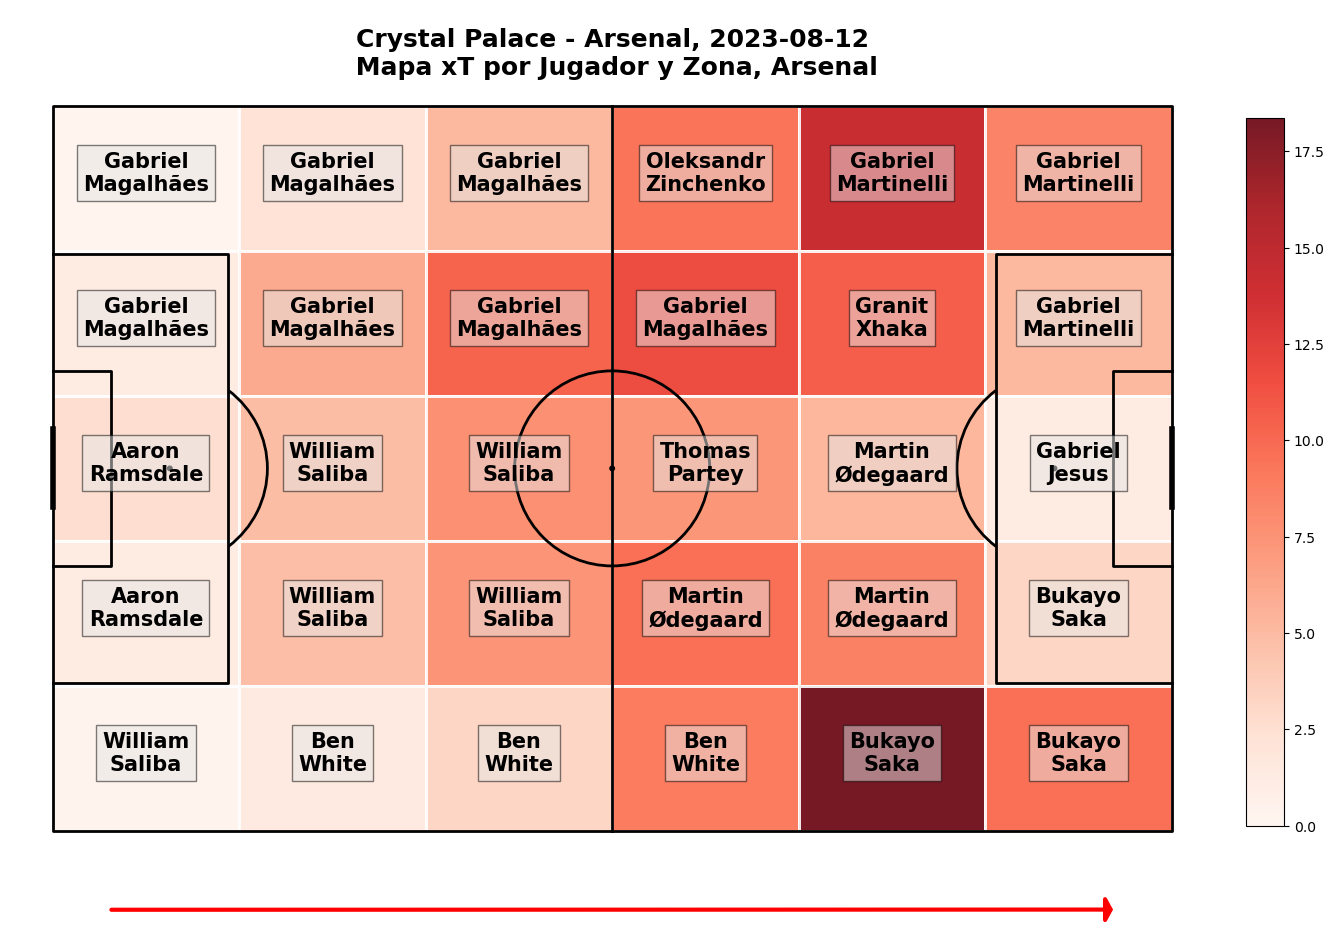

In [29]:
pitch = Pitch(line_zorder=2, line_color='black',pitch_type='uefa')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

b = (6,5)

bin_statistic = pitch.bin_statistic(mov.start_x, mov.start_y, statistic='count', bins=b, normalize=False)
bin_statistic['statistic'] = grouped_array
#normalize by number of games

#make a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='white', ax=ax['pitch'], alpha=0.9, vmin = 0)
for i in range(bin_statistic['cx'].shape[0]):
    for j in range(bin_statistic['cy'].shape[1]):
        tup = (j+1,5-i)
        s = players[players.start_sector==tup]
        if s.shape[0]>0:
            jug = s.player_name.values[0]
            jug = jug.replace(' ','\n')
            pitch.annotate("{}".format(jug), xy=(bin_statistic['cx'][i][j], bin_statistic['cy'][i][j]+.5), c='black', va='center', ha='center', weight = "bold", size=15, ax=ax["pitch"], zorder = 4,bbox={'facecolor': '.9', 'edgecolor':'black', 'boxstyle':'square', 'alpha' : 0.5})
#legend to our plot
plt.annotate('', xy=(0.95, -0.005), xycoords='axes fraction', xytext=(0.05, -0.01), 
            arrowprops=dict(arrowstyle='-|>, head_width=0.75', color='red',lw=3))
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle("{} - {}, 2023-08-12\n Mapa xT por Jugador y Zona, {}".format(games[games.game_id == df_events.game_id.values[0]].home_team.values[0], games[games.game_id == df_events.game_id.values[0]].away_team.values[0],mov.team_name.values[0]), fontsize = 18, weight='bold')
plt.show()

In [30]:
b = (10,7)
bm = (4,4)
mov = df_events[(df_events.xT!=0) & (df_events.team_name == 'Arsenal') & (df_events.result_id==1) ]
mov = mov[ mov.type_name.isin(["pass","cross"]) ]

mov["start_sector"] = mov.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.start_x), np.ravel(row.start_y),
                                                               values = "None", statistic="count",
                                                               bins=b, range=[[0, instat_x], [0, instat_y]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

mov["end_sector"] = mov.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.end_x), np.ravel(row.end_y),
                                                               values = "None", statistic="count",
                                                               bins=b, range=[[0, instat_x], [0, instat_y]],
                                                               expand_binnumbers=True)[3]]), axis = 1)


mov = mov[mov.start_sector==bm]
grouped = mov.groupby('end_sector')['xT'].sum().reset_index()
list_tuples= []
for i in range(1,b[0]+1):
    for j in reversed(range(1,b[1]+1)):
        list_tuples.append((i,j))
index_base = pd.DataFrame(np.array(list_tuples),columns=['x','y'])
index_base['index'] = list(zip(index_base.x, index_base.y))
index_base.drop(['x','y'],inplace=True,axis=1)

grouped = pd.merge(index_base,grouped,how='left',left_on='index',right_on='end_sector')
grouped = grouped.fillna(0)

grouped_array = np.array(grouped['xT'].values).reshape(b[0],b[1]).T

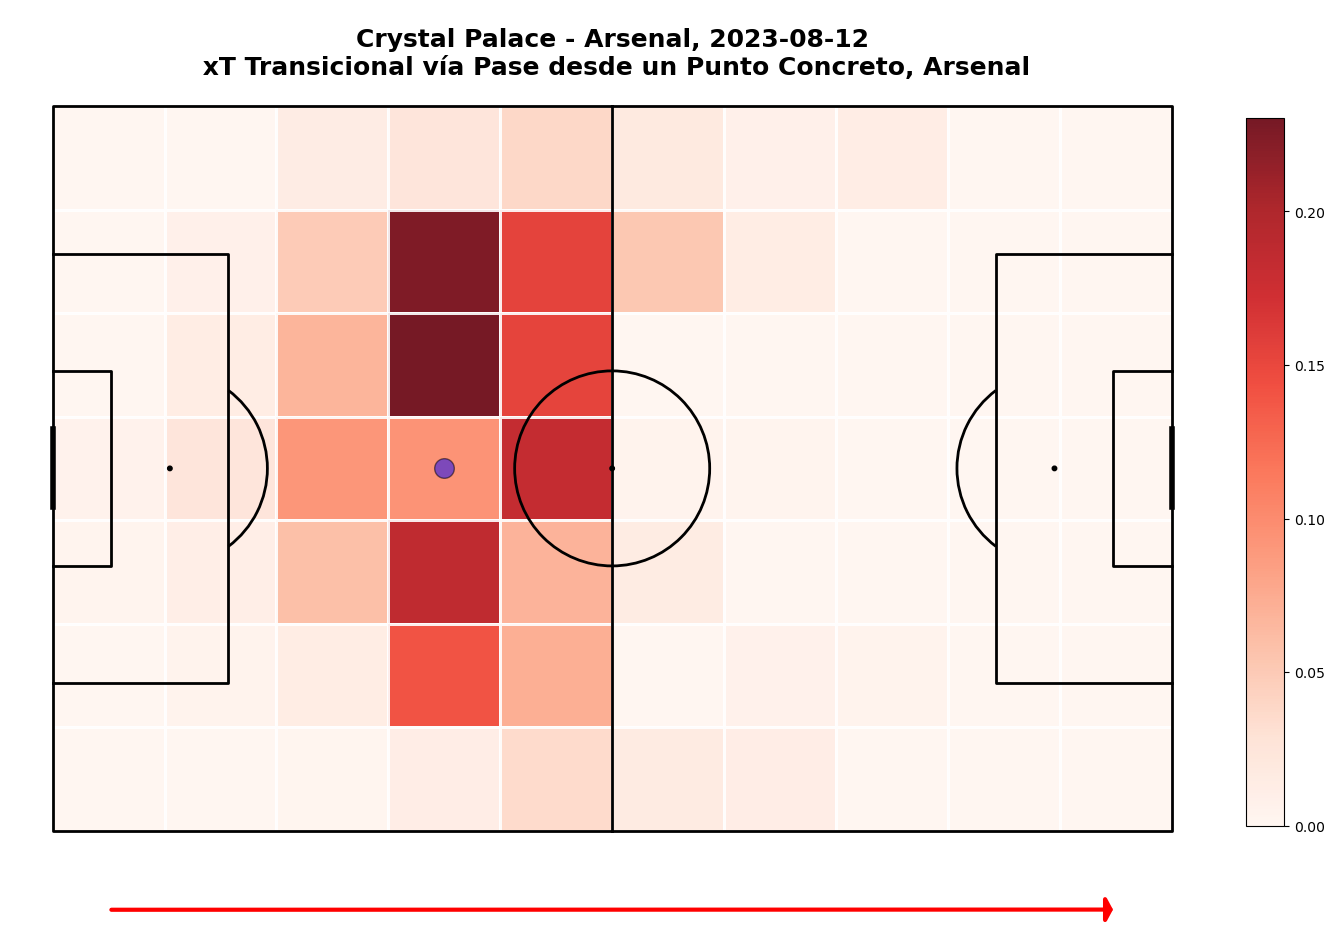

In [31]:
pitch = Pitch(line_zorder=2, line_color='black',pitch_type='uefa')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)



bin_statistic = pitch.bin_statistic(mov.end_x, mov.end_y, statistic='count', bins=b, normalize=False)
bin_statistic['statistic'] = grouped_array
#normalize by number of games

#make a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='white', ax=ax['pitch'], alpha=0.9, vmin = 0)
pitch.scatter(bin_statistic['cx'][bm[1]-1][bm[0]-1],
              bin_statistic['cy'][b[1] - bm[1]][bm[0]-1],
              alpha = 0.5, color = "blue", ax=ax['pitch'], edgecolors="black",s=200)
plt.annotate('', xy=(0.95, -0.005), xycoords='axes fraction', xytext=(0.05, -0.01), 
            arrowprops=dict(arrowstyle='-|>, head_width=0.75', color='red',lw=3))
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle("{} - {}, 2023-08-12\n xT Transicional vía Pase desde un Punto Concreto, {}".format(games[games.game_id == df_events.game_id.values[0]].home_team.values[0], games[games.game_id == df_events.game_id.values[0]].away_team.values[0],mov.team_name.values[0]), fontsize = 18, weight='bold')
plt.show()